In [3]:
from Bio import SeqIO
from collections import Counter
import pandas as pd 
import re
import requests
import json
import time
import glob
import pprint
import seaborn as sns
import pylab as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import pycountry 
import pycountry_convert as pc
pp = pprint.PrettyPrinter()
import numpy as np
from tabulate import tabulate
import math

In [2]:
# clean this code sheet
# change the balance vis: adjust axis labels and adjust to the 49 countries


In [6]:
df_patents_all = pd.read_csv('PATH\data\CoP.csv')

In [7]:
len(set(df_patents_all['patent_id'][(df_patents_all['patent_type']  == 'GRANTED_PATENT') & (df_patents_all['edited_company_country'].notna())]))

6434

In [8]:
df_patentsg = df_patents_all[df_patents_all['patent_type'] == 'GRANTED_PATENT'].dropna(subset = ['edited_company_country'])

## 1. Mapp institutions

In [9]:
# how many patent owners? 
df_patentsg[['edited_company_name']].dropna().drop_duplicates()

,edited_company_name
19,BAYER
20,DIVERGENCE
21,IDEXX LABORATORIES
22,UNIVERSITY OF COLORADO
23,UNIVERSITY LICENSE EQUITY HOLDING
...,...
21682,ALTEROBIOTECH
21689,SHANGHAI KANDA BIOTECHNOLOGY CO.
21690,SHANGHAI CELGEN BIO-PHARMACEUTICAL CO.
21731,TOYOTA BOSHOKU KABUSHIKI KAISHA


In [10]:
fractional_counts_inst = []
fractional_counts_country = []
patent_counts_inst = {}
patent_counts_country = {}
for pat in list(df_patentsg['patent_id']): 
    if pat not in patent_counts_inst:
        patent_counts_inst[pat] = len(df_patentsg[['patent_id', 'edited_company_name']][df_patentsg['patent_id'] == pat].drop_duplicates())
        patent_counts_country[pat] = len(df_patentsg[['patent_id', 'edited_company_country']][df_patentsg['patent_id'] == pat].drop_duplicates())
    fractional_counts_inst.append(1/patent_counts_inst[pat])
    fractional_counts_country.append(1/patent_counts_country[pat])

In [11]:
df_patentsg['fractional_count_inst'] = fractional_counts_inst
df_patentsg['fractional_count_country'] = fractional_counts_country

In [12]:
df_patentsg['patent_citations_fract'] = df_patentsg['patent_citations']*df_patentsg['fractional_count_country']


In [13]:
# add econ group
# load g77 and OECD data, assign overlapping to g77
g77 = pd.read_csv('PATH\data\g77.csv')
oecd = pd.read_csv('PATH\data\oecd.csv')

delete_from_oecd = []

for i in list(g77['Code']): 
    if i in list(oecd['Code']):
        delete_from_oecd.append(i)

for i in list(g77['Code']): 
    if i in list(oecd['Code']):
        delete_from_oecd.append(i)        

oecd_clean = [x for x in list(oecd['Code']) if x not in delete_from_oecd]

econ_group = []
for i in list(df_patentsg['edited_company_country']):
    if i in [pc.country_alpha3_to_country_alpha2(x) for x in oecd_clean]: 
        econ_group.append('OECD')
    elif i in ['RU','BR','IN','CN','ZA']:
        econ_group.append('BRICS')
    elif i in [pc.country_alpha3_to_country_alpha2(x) for x in g77['Code'] if x not in ['RU','BR','IN','CN','ZA']]:
        econ_group.append('G77')
    elif pd.isna(i): 
        econ_group.append(np.nan)
    else: 
        econ_group.append('other')
        
df_patentsg['econ_group'] = econ_group

In [14]:
# Affiliations 
df_affiliations = df_patentsg[['patent_id','edited_company_country','edited_company_name', 'fractional_count_inst', 'econ_group']].drop_duplicates()
df_patents = df_affiliations.groupby(['edited_company_name'])['fractional_count_inst'].sum().reset_index(name='Patents_fract').sort_values(['Patents_fract'], ascending=False)
df_affiliations_vis = pd.merge(df_patents, df_affiliations[['edited_company_name', 'edited_company_country', 'econ_group']].drop_duplicates(), how = 'left', on = 'edited_company_name').rename(columns = {'edited_company_name':'Affiliation','Patents_fract':'Patents','econ_group':'Econ Group','edited_company_country':'Country'})

In [15]:
print(tabulate(df_affiliations_vis[['Affiliation', 'Patents', 'Country', 'Econ Group']][:20].set_index('Affiliation'), headers='keys', tablefmt='fancy_grid',  numalign="left", stralign = "left"))


╒═════════════════════════════════╤═══════════╤═══════════╤══════════════╕
│ Affiliation                     │ Patents   │ Country   │ Econ Group   │
╞═════════════════════════════════╪═══════════╪═══════════╪══════════════╡
│ UNIVERSITY OF CALIFORNIA        │ 192       │ US        │ OECD         │
├─────────────────────────────────┼───────────┼───────────┼──────────────┤
│ DU PONT                         │ 170.533   │ US        │ OECD         │
├─────────────────────────────────┼───────────┼───────────┼──────────────┤
│ HARVARD UNIVERSITY              │ 114.533   │ US        │ OECD         │
├─────────────────────────────────┼───────────┼───────────┼──────────────┤
│ STANFORD UNIVERSITY             │ 109.333   │ US        │ OECD         │
├─────────────────────────────────┼───────────┼───────────┼──────────────┤
│ BAYER                           │ 105.667   │ DE        │ OECD         │
├─────────────────────────────────┼───────────┼───────────┼──────────────┤
│ OPKO                   

## 2. Map countries

In [16]:
#Countries
df_countries = df_patentsg[['patent_id','edited_company_country','fractional_count_country', 'econ_group','patent_citations','patent_citations_fract']].drop_duplicates()

#papers
df_patent_country = df_countries.groupby(['edited_company_country'])['fractional_count_country'].sum().reset_index(name='Patents_fract').sort_values(['Patents_fract'], ascending=False)

#citations
df_cit_country = df_countries.groupby(['edited_company_country'])['patent_citations_fract'].sum().reset_index(name='Patent citations_fract').sort_values(['Patent citations_fract'], ascending=False)
df_patent_country['Patent citations_fract'] = df_cit_country['Patent citations_fract']

df_countries_vis = pd.merge(df_patent_country, df_countries[['edited_company_country', 'econ_group']].drop_duplicates(), how = 'left', on = 'edited_company_country') #.rename(columns = {'Papers_fract':'Papers','econ_group':'Econ Group','affiliation_country_ed':'Country'})

In [17]:
print(tabulate(df_countries_vis[:20], headers='keys', tablefmt='fancy_grid', numalign="left", stralign = "left"))


╒════╤══════════════════════════╤═════════════════╤══════════════════════════╤══════════════╕
│    │ edited_company_country   │ Patents_fract   │ Patent citations_fract   │ econ_group   │
╞════╪══════════════════════════╪═════════════════╪══════════════════════════╪══════════════╡
│ 0  │ US                       │ 3655.75         │ 56018.5                  │ OECD         │
├────┼──────────────────────────┼─────────────────┼──────────────────────────┼──────────────┤
│ 1  │ JP                       │ 458.5           │ 3163.17                  │ OECD         │
├────┼──────────────────────────┼─────────────────┼──────────────────────────┼──────────────┤
│ 2  │ DE                       │ 388             │ 4367.67                  │ OECD         │
├────┼──────────────────────────┼─────────────────┼──────────────────────────┼──────────────┤
│ 3  │ GB                       │ 363.333         │ 13548.3                  │ OECD         │
├────┼──────────────────────────┼─────────────────┼─────────

In [18]:
df_countries.to_csv('PATH\data\CoP_fractional_scores.csv')

In [19]:
df_countries = pd.read_csv('PATH\data\CoP_fractional_scores.csv')

In [20]:
#merge with science table
df_sci_table = pd.read_csv('PATH\data\df_countries_vis_fract.csv')
df_sci_pat_table = pd.merge(df_sci_table.drop(columns={'Unnamed: 0','country_paper_percentage', 'country_sci_cit_percentage', 'Econ Group'}).rename(columns = {'Citations by sci_fract':'Citations by sci','Citations by pat_fract': 'Citations by pat', 'Av citations by sci_fract': 'Av citations by sci', 'Av citations by pat_fract':'Av citations by pat', 'Med citations by sci_fract': 'Med citations by sci', 'Med citations by pat_fract': 'Med citations by pat'}), df_countries_vis.rename(columns = {'edited_company_country':'Country', 'Patents_fract':'Linked patents'}).drop(columns={'Patent citations_fract','econ_group'}), on = 'Country', how = 'left')

In [21]:
df_sci_pat_table[df_sci_pat_table['Country'] == 'MX']

,Country,Papers,Citations by sci,Citations by pat,Av citations by sci,Av citations by pat,Linked patents
24,MX,149.146861,3975.422511,16.833333,26.654416,0.112864,3.0


In [23]:
df_sci_pat_table['Country_full'] = [pc.country_alpha2_to_country_name(x) for x in list(df_sci_pat_table['Country'])]

In [34]:
# add knowledge balances
df_knowledge = pd.read_csv('PATH\data\CoR-CoP_flow.csv').drop(columns = {'Unnamed: 0'})

In [25]:
df_sci_pat_table_final = pd.merge(df_sci_pat_table, df_knowledge[['Country', 'External knowledge provision balance']], how = 'outer')

In [27]:
df_sci_pat_table_final

,Country,Papers,Citations by sci,Citations by pat,Av citations by sci,Av citations by pat,Linked patents,Country_full,External knowledge provision balance
0,US,5583.366251,470722.453845,8619.637312,84.308002,1.543807,3655.750000,United States,0.584243
1,CN,2994.991179,84321.765172,498.246836,28.154262,0.166360,49.500000,China,2.602417
2,JP,2697.564292,133214.787320,3046.216799,49.383360,1.129247,458.500000,Japan,2.837159
3,DE,1160.028913,91812.530937,1313.096836,79.146761,1.131952,388.000000,Germany,1.023670
4,FR,1090.423791,76576.312575,753.571836,70.226194,0.691082,66.333333,France,4.154071
...,...,...,...,...,...,...,...,...,...
144,GS,0.166667,2.666667,0.000000,16.000000,0.000000,NaN,South Georgia and the South Sandwich Islands,NaN
145,UZ,0.166667,3.666667,0.000000,22.000000,0.000000,NaN,Uzbekistan,NaN
146,MR,0.166667,0.000000,0.000000,0.000000,0.000000,NaN,Mauritania,NaN
147,GA,0.142857,13.142857,0.000000,92.000000,0.000000,NaN,Gabon,NaN


In [21]:
df_sci_pat_table_final.index -= 1 

In [209]:
print(tabulate(df_sci_pat_table_final[['Country_full', 'Papers', 'Citations by sci', 'Av citations by sci', 'Citations by pat', 'Av citations by pat', 'Linked patents', 'External knowledge provision balance']][:20].rename(columns = {'Country_full':'Country', 'External knowledge provision balance':'Ext prov/use balance'}).replace({'Country': {'Korea, Republic of':'South Korea','Russian Federation':'Russia','Taiwan, Province of China': 'Taiwan'}}), headers='keys', tablefmt='fancy_grid', numalign="left", stralign = "left"))


╒════╤════════════════╤══════════╤════════════════════╤═══════════════════════╤════════════════════╤═══════════════════════╤══════════════════╤════════════════════════╕
│    │ Country        │ Papers   │ Citations by sci   │ Av citations by sci   │ Citations by pat   │ Av citations by pat   │ Linked patents   │ Ext prov/use balance   │
╞════╪════════════════╪══════════╪════════════════════╪═══════════════════════╪════════════════════╪═══════════════════════╪══════════════════╪════════════════════════╡
│ 0  │ United States  │ 5583.37  │ 470722             │ 84.308                │ 8619.64            │ 1.54381               │ 3655.75          │ 0.584243               │
├────┼────────────────┼──────────┼────────────────────┼───────────────────────┼────────────────────┼───────────────────────┼──────────────────┼────────────────────────┤
│ 1  │ China          │ 2994.99  │ 84321.8            │ 28.1543               │ 498.247            │ 0.16636               │ 49.5             │ 2.60242    

In [28]:
df_sci_pat_plot = pd.merge(df_sci_pat_table, df_sci_table[['Country', 'Econ Group']], on = 'Country')

In [61]:
df_sci_pat_plot.rename(columns = {'Country_full':'Country'}).replace({'Country': {'Korea, Republic of':'South Korea', 'Taiwan, Province of China': 'Taiwan'}})


,Country,Papers,Citations by sci,Citations by pat,Av citations by sci,Av citations by pat,Linked patents,Country,Econ Group
0,US,5583.366251,470722.453845,8619.637312,84.308002,1.543807,3655.750000,United States,OECD
1,CN,2994.991179,84321.765172,498.246836,28.154262,0.166360,49.500000,China,BRICS
2,JP,2697.564292,133214.787320,3046.216799,49.383360,1.129247,458.500000,Japan,OECD
3,DE,1160.028913,91812.530937,1313.096836,79.146761,1.131952,388.000000,Germany,OECD
4,FR,1090.423791,76576.312575,753.571836,70.226194,0.691082,66.333333,France,OECD
...,...,...,...,...,...,...,...,...,...
144,GS,0.166667,2.666667,0.000000,16.000000,0.000000,NaN,South Georgia and the South Sandwich Islands,other
145,UZ,0.166667,3.666667,0.000000,22.000000,0.000000,NaN,Uzbekistan,other
146,MR,0.166667,0.000000,0.000000,0.000000,0.000000,NaN,Mauritania,G77
147,GA,0.142857,13.142857,0.000000,92.000000,0.000000,NaN,Gabon,G77


In [62]:
# add percentages
df_sci_perc = pd.read_csv('PATH\data\table_COR_fract.csv')
df_sci_pat_plot_perc = pd.merge(df_sci_pat_plot, df_sci_perc[['Country', 'country_paper_percentage']], on = 'Country')
df_sci_pat_plot_perc['percentage_label'] = [f'{x:.2f}%' for x in df_sci_pat_plot_perc['country_paper_percentage']]

In [172]:
countries_label = []
econ_groups_label = []
for country in list(df_sci_pat_plot_perc['Country_full']): 
    if list(df_sci_pat_plot_perc['country_paper_percentage'][df_sci_pat_plot_perc['Country_full'] == country])[0] >= 0.3: 
        countries_label.append(country)
    else: 
        countries_label.append('other')
    econ_groups_label.append(list(df_sci_pat_plot_perc['Econ Group'][df_sci_pat_plot_perc['Country_full'] == country])[0])

In [173]:
df_sci_pat_plot_perc['countries_label'] = countries_label
df_sci_pat_plot_perc['econ_groups_label'] = econ_groups_label

In [174]:
df_sci_pat_plot_perc_label = df_sci_pat_plot_perc.groupby(['countries_label', 'Econ Group'])['Papers'].sum().reset_index(name='Papers').sort_values(['Papers'],ascending = True)

In [179]:
import plotly.express as px
import plotly.io as pio


tab20_colors = ['#1f77b4','#2ca02c','#d62728','#ff7f0e','#d62728','#1f77b4']
fig = px.treemap(
    df_sci_pat_plot_perc_label.replace({
        'countries_label':{
            'Korea, Republic of':'South Korea',
            'Russian Federation':'Russia',
            'Taiwan, Province of China': 'Taiwan'
        }
    }),
    path=['Econ Group', 'countries_label'],
    values='Papers',  # Use 'country_paper_percentage' column
    color='Econ Group',
    color_discrete_sequence=tab20_colors,
    # Show 'percentage_label' as the text labels
)

fig.data[0].textinfo = 'label+percent entry'

fig.layout.hovermode = False


fig.update_layout(
    margin = dict(t=5, l=5, r=5, b=5),
    #title=dict(
    #    text="Marine genetic studies per country and economic group", 
    #    font=dict(family="Arial", size=26, color="black"),
    #    x=0.5,
    #    y=0.95),
    font=dict(family="Arial", size=22, color="black")
)

fig.show()
pio.write_image(fig, 'PATH\plots\paper_plot.jpg', width=1000, height=800)
pio.write_image(fig, 'PATH\plots\paper_plot.svg', width=1000, height=800)


In [150]:
df_sci_pat_plot_perc_label

,countries_label,econ_groups_label,Papers
24,other,BRICS,74.004671
1,Belgium,OECD,152.111616
5,Denmark,OECD,153.074339
9,Israel,OECD,156.821825
21,Thailand,G77,162.073779
19,Switzerland,OECD,166.849537
16,Russian Federation,BRICS,182.662338
13,Netherlands,OECD,192.476929
15,Portugal,OECD,222.044456
27,other,other,222.110913


In [ ]:
import plotly.express as px

# Assuming you have the necessary data and DataFrame df_sci_pat_plot_perc_label is available

# Calculate percentage values and add as labels for countries and groups
df_sci_pat_plot_perc_label['country_percentage_label'] = [f'{x:.2f}%' for x in df_sci_pat_plot_perc_label['country_paper_percentage']]
df_sci_pat_plot_perc_label['group_percentage_label'] = [f'{x:.2f}%' for x in df_sci_pat_plot_perc_label['group_paper_percentage']]

tab20_colors = ['#2ca02c', '#ff7f0e', '#d62728', '#1f77b4']

# Create the treemap figure
fig = px.treemap(
    df_sci_pat_plot_perc_label.replace({
        'countries_label': {
            'Korea, Republic of': 'South Korea',
            'Russian Federation': 'Russia',
            'Taiwan, Province of China': 'Taiwan'
        }
    }),
    path=['econ_groups_label', 'countries_label'],
    values='Papers',
    color='econ_groups_label',
    color_discrete_sequence=tab20_colors,
    custom_data=['country_percentage_label', 'group_percentage_label']  # Include percentage data for custom hover text
)

# Update the layout and hovertemplate
fig.update_layout(
    margin=dict(t=10, l=10, r=10, b=10),
    title=dict(
        text="Marine genetic studies per country and economic group",
        font=dict(family="Arial", size=26, color="black"),
        x=0.5,
        y=0.95
    ),
    font=dict(family="Arial", size=20, color="black"),
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Arial",
        namelength=-1  # Show full name on hover
    )
)

# Define hovertemplate to include both country and group percentages
fig.update_traces(hovertemplate='Papers: %{value}<br>Country Percentage: %{customdata[0]}<br>Group Percentage: %{customdata[1]}')

# Add annotations for group percentages
annotations = []
groups = df_sci_pat_plot_perc_label['econ_groups_label'].unique()
for group in groups:
    df_group = df_sci_pat_plot_perc_label[df_sci_pat_plot_perc_label['econ_groups_label'] == group]
    annotation = dict(
        x=df_group['econ_groups_label'].iloc[0],
        y=df_group['countries_label'].iloc[0],
        text=df_group['group_percentage_label'].iloc[0],
        font=dict(size=14, color='black'),
        showarrow=False
    )
    annotations.append(annotation)

fig.update_layout(annotations=annotations)

fig.show()


In [23]:
# run the correlations here

In [22]:
df_sci_country70 =  pd.read_csv('PATH\data\df_countries_vis_nononesense_fract.csv')

In [23]:
df_sci_country_all = pd.read_csv('PATH\data\df_countries_vis_fract.csv')

In [24]:
df_corrs = pd.merge(df_sci_country70, df_patent_country.rename(columns = {'edited_company_country':'Country', 'Patents_fract':'Patents'}), how ='left', on = 'Country').reset_index(drop =True).rename(columns = {'Granted patents':'Patents'})
df_corrs_noUS = pd.merge(df_sci_country70[df_sci_country70['Country'] != 'US'], df_patent_country.rename(columns = {'edited_company_country':'Country', 'Patents_fract':'Patents'}), how ='left', on = 'Country').reset_index(drop =True).rename(columns = {'Granted patents':'Patents'})

In [25]:
import math
df_corrs['Papers_log'] = [math.log(x) for x in df_corrs['Papers']]
df_corrs['Patents_log'] = [math.log(x) for x in df_corrs['Patents']]

In [26]:
df_corrs

,Unnamed: 0,index,Country,Papers,Citations by sci_fract,Citations by pat_fract,Av citations by sci_fract,Av citations by pat_fract,Econ Group,country_paper_percentage,country_sci_cit_percentage,Patents,Patent citations_fract,Papers_log,Patents_log
0,0,0,US,5583.366251,470722.453845,8619.637312,84.308002,1.543807,OECD,24.034119,34.655162,3655.750000,56018.500000,8.627547,8.204057
1,1,1,CN,2994.991179,84321.765172,498.246836,28.154262,0.166360,BRICS,12.892218,6.207871,49.500000,77.500000,8.004697,3.901973
2,2,2,JP,2697.564292,133214.787320,3046.216799,49.383360,1.129247,OECD,11.611916,9.807435,458.500000,3163.166667,7.900105,6.127960
3,3,3,DE,1160.028913,91812.530937,1313.096836,79.146761,1.131952,OECD,4.993452,6.759351,388.000000,4367.666667,7.056200,5.961005
4,4,4,FR,1090.423791,76576.312575,753.571836,70.226194,0.691082,OECD,4.693831,5.637642,66.333333,391.166667,6.994322,4.194693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,65,66,AE,6.878968,557.753968,0.000000,81.081050,0.000000,G77,0.029611,0.041063,1.000000,0.000000,1.928469,0.000000
66,66,67,UA,6.333333,467.083333,1.500000,73.750000,0.236842,other,0.027262,0.034387,NaN,NaN,1.845827,NaN
67,67,68,VE,5.959524,188.202381,0.000000,31.580104,0.000000,G77,0.025653,0.013856,NaN,NaN,1.784991,NaN
68,68,69,MT,5.183333,90.266667,0.000000,17.414791,0.000000,other,0.022312,0.006646,NaN,NaN,1.645448,NaN


In [211]:
from scipy.stats import pearsonr
import numpy as np
rho = df_corrs[['Papers', 'Av citations by sci_fract', 'Av citations by pat_fract', 'Patents']].rename(columns={'Av citations by sci_fract':'Av citations by sci', 'Av citations by pat_fract':'Av citations by pat'}).corr()
pval = df_corrs[['Papers', 'Av citations by sci_fract', 'Av citations by pat_fract', 'Patents']].rename(columns={'Av citations by sci_fract':'Av citations by sci', 'Av citations by pat_fract':'Av citations by pat'}).corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))



print(tabulate(rho.round(2).astype(str) + p, headers='keys', tablefmt='fancy_grid', numalign="left", stralign = "left"))


╒═════════════════════╤══════════╤═══════════════════════╤═══════════════════════╤═══════════╕
│                     │ Papers   │ Av citations by sci   │ Av citations by pat   │ Patents   │
╞═════════════════════╪══════════╪═══════════════════════╪═══════════════════════╪═══════════╡
│ Papers              │ 1.0***   │ 0.27*                 │ 0.13                  │ 0.84***   │
├─────────────────────┼──────────┼───────────────────────┼───────────────────────┼───────────┤
│ Av citations by sci │ 0.27*    │ 1.0***                │ 0.36**                │ 0.37*     │
├─────────────────────┼──────────┼───────────────────────┼───────────────────────┼───────────┤
│ Av citations by pat │ 0.13     │ 0.36**                │ 1.0***                │ 0.17      │
├─────────────────────┼──────────┼───────────────────────┼───────────────────────┼───────────┤
│ Patents             │ 0.84***  │ 0.37*                 │ 0.17                  │ 1.0***    │
╘═════════════════════╧══════════╧════════════════

In [30]:
from scipy.stats import pearsonr
import numpy as np
rho = df_corrs_noUS[['Papers', 'Av citations by sci_fract', 'Av citations by pat_fract', 'Patents']].corr()
pval = df_corrs_noUS[['Papers', 'Av citations by sci_fract', 'Av citations by pat_fract', 'Patents']].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))



print(tabulate(rho.round(2).astype(str) + p, headers='keys', tablefmt='fancy_grid', numalign="left", stralign = "left"))


╒═══════════════════════════╤══════════╤═════════════════════════════╤═════════════════════════════╤═══════════╕
│                           │ Papers   │ Av citations by sci_fract   │ Av citations by pat_fract   │ Patents   │
╞═══════════════════════════╪══════════╪═════════════════════════════╪═════════════════════════════╪═══════════╡
│ Papers                    │ 1.0***   │ 0.12                        │ 0.06                        │ 0.6***    │
├───────────────────────────┼──────────┼─────────────────────────────┼─────────────────────────────┼───────────┤
│ Av citations by sci_fract │ 0.12     │ 1.0***                      │ 0.34**                      │ 0.44**    │
├───────────────────────────┼──────────┼─────────────────────────────┼─────────────────────────────┼───────────┤
│ Av citations by pat_fract │ 0.06     │ 0.34**                      │ 1.0***                      │ 0.22      │
├───────────────────────────┼──────────┼─────────────────────────────┼──────────────────────────

In [31]:
from scipy.stats import pearsonr
import numpy as np
rho = df_corrs[['Papers_log', 'Av citations by sci_fract', 'Av citations by pat_fract', 'Patents_log']].corr()
pval = df_corrs[['Papers_log', 'Av citations by sci_fract', 'Av citations by pat_fract', 'Patents_log']].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))



print(tabulate(rho.round(2).astype(str) + p, headers='keys', tablefmt='fancy_grid', numalign="left", stralign = "left"))


╒═══════════════════════════╤══════════════╤═════════════════════════════╤═════════════════════════════╤═══════════════╕
│                           │ Papers_log   │ Av citations by sci_fract   │ Av citations by pat_fract   │ Patents_log   │
╞═══════════════════════════╪══════════════╪═════════════════════════════╪═════════════════════════════╪═══════════════╡
│ Papers_log                │ 1.0***       │ 0.34**                      │ 0.21                        │ 0.77***       │
├───────────────────────────┼──────────────┼─────────────────────────────┼─────────────────────────────┼───────────────┤
│ Av citations by sci_fract │ 0.34**       │ 1.0***                      │ 0.36**                      │ 0.59***       │
├───────────────────────────┼──────────────┼─────────────────────────────┼─────────────────────────────┼───────────────┤
│ Av citations by pat_fract │ 0.21         │ 0.36**                      │ 1.0***                      │ 0.28          │
├───────────────────────────┼───

In [32]:
df_corrs_all = pd.merge(df_sci_country_all, df_patent_country.rename(columns = {'edited_company_country':'Country', 'Patents_fract':'Patents'}), how ='left', on = 'Country').reset_index(drop =True).rename(columns = {'Granted patents':'Patents'})
#df_corrs_noUS = pd.merge(df_sci_country49[df_sci_country49['Country'] != 'US'], df_patent_countries, how ='left', on = 'Country').reset_index(drop =True).rename(columns = {'Granted patents':'Patents'})

In [33]:
# if taking all countries, it is still signficantly correlated
from scipy.stats import pearsonr
import numpy as np
rho = df_corrs_all[['Papers', 'Av citations by sci_fract', 'Av citations by pat_fract', 'Patents']].fillna(0).corr()
pval = df_corrs_all[['Papers', 'Av citations by sci_fract', 'Av citations by pat_fract', 'Patents']].fillna(0).corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))



print(tabulate(rho.round(2).astype(str) + p, headers='keys', tablefmt='fancy_grid', numalign="left", stralign = "left"))


╒═══════════════════════════╤══════════╤═════════════════════════════╤═════════════════════════════╤═══════════╕
│                           │ Papers   │ Av citations by sci_fract   │ Av citations by pat_fract   │ Patents   │
╞═══════════════════════════╪══════════╪═════════════════════════════╪═════════════════════════════╪═══════════╡
│ Papers                    │ 1.0***   │ 0.16                        │ 0.16                        │ 0.84***   │
├───────────────────────────┼──────────┼─────────────────────────────┼─────────────────────────────┼───────────┤
│ Av citations by sci_fract │ 0.16     │ 1.0***                      │ 0.18*                       │ 0.16*     │
├───────────────────────────┼──────────┼─────────────────────────────┼─────────────────────────────┼───────────┤
│ Av citations by pat_fract │ 0.16     │ 0.18*                       │ 1.0***                      │ 0.15      │
├───────────────────────────┼──────────┼─────────────────────────────┼──────────────────────────

## 3. Construct the balance vis (total)

In [180]:
df_science_vs_patent_totals = pd.merge(left = df_sci_pat_table.drop(columns = {'Linked patents'}).rename(columns = {'Papers':'paper count'}) , right= df_patent_country.rename(columns = {'edited_company_country':'Country', 'Patents_fract':'patent count'}), how = 'outer', on ='Country').rename(columns = {'Country':'affiliation_country'})

In [181]:
# add econ group
# load g77 and OECD data, assign overlapping to g77
g77 = pd.read_csv('PATH\data\g77.csv')
oecd = pd.read_csv('PATH\data\oecd.csv')

delete_from_oecd = []

for i in list(g77['Code']): 
    if i in list(oecd['Code']):
        delete_from_oecd.append(i)

for i in list(g77['Code']): 
    if i in list(oecd['Code']):
        delete_from_oecd.append(i)        

oecd_clean = [x for x in list(oecd['Code']) if x not in delete_from_oecd]

econ_group = []
for i in list(df_science_vs_patent_totals['affiliation_country']):
    if i in [pc.country_alpha3_to_country_alpha2(x) for x in oecd_clean]: 
        econ_group.append('OECD')
    elif i in ['RU','BR','IN','CN','ZA']:
        econ_group.append('BRICS')
    elif i in [pc.country_alpha3_to_country_alpha2(x) for x in g77['Code'] if x not in ['RU','BR','IN','CN','ZA']]:
        econ_group.append('G77')
    elif pd.isna(i): 
        econ_group.append(np.nan)
    else: 
        econ_group.append('other')
        
df_science_vs_patent_totals['econ_group'] = econ_group

In [182]:
df_science_vs_patent_totals.to_csv('PATH\data\science_patent_totals[OBIS_and_patents].csv',index=False)

In [183]:
df_science_vs_patent_totals_noUS = df_science_vs_patent_totals[df_science_vs_patent_totals['affiliation_country'] != 'US'].reset_index()

In [185]:
# log scale for citation totals
df_science_vs_patent_totals_log = df_science_vs_patent_totals.copy().fillna(0)
df_science_vs_patent_totals_log['paper count_log'] = [math.log(x+1) for x in list(df_science_vs_patent_totals_log['paper count'])]
df_science_vs_patent_totals_log['patent count_log'] = [math.log(x+1) for x in list(df_science_vs_patent_totals_log['patent count'])]

  

In [186]:
len(df_science_vs_patent_totals_log[df_science_vs_patent_totals_log['patent count'] >=0])

150

In [ ]:
sci_av_top = df_countries_vis['Av citations by sci_fract'].quantile(0.99)
pat_av_top = df_countries_vis['Av citations by pat_fract'].quantile(0.99)

df_countries_vis_nononesense = df_countries_vis[(df_countries_vis['Av citations by sci_fract']<sci_av_top)&(df_countries_vis['Av citations by pat_fract']<pat_av_top)&(df_countries_vis['Papers']>=5)].reset_index()

<Figure size 9360x12960 with 0 Axes>

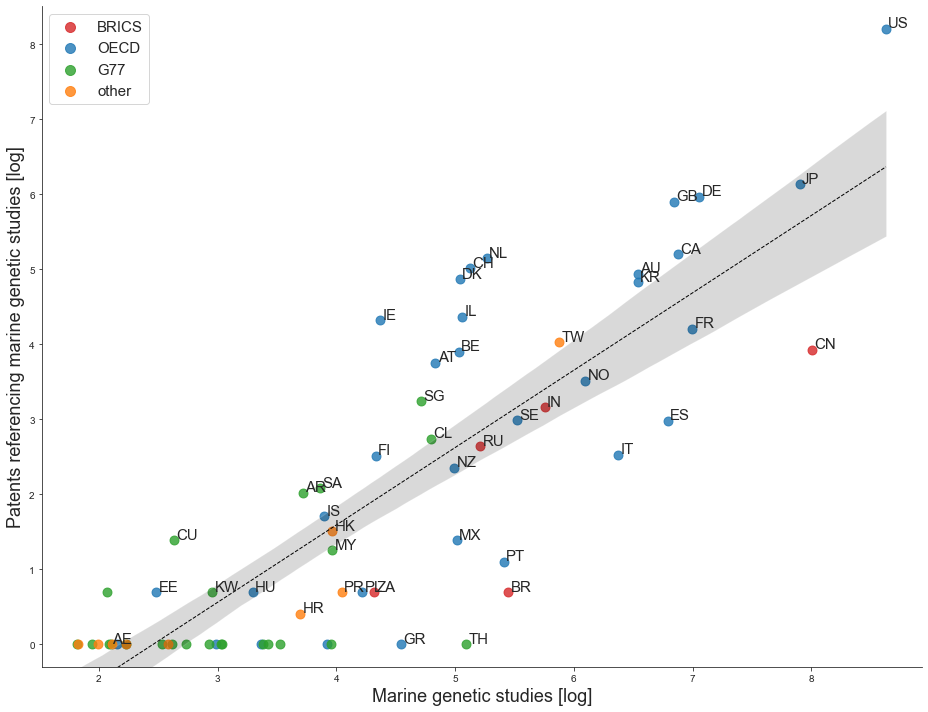

In [210]:
# Visualizing
# could add country/econ group colors

plt.figure(figsize=(130,180))
sns.set_style('white')
sns.set_style('ticks')

sci_av_top = df_science_vs_patent_totals_log['Av citations by sci'].quantile(0.99)
pat_av_top = df_science_vs_patent_totals_log['Av citations by pat'].quantile(0.99)

df_science_vs_patent_totals_log_70 = df_science_vs_patent_totals_log[(df_science_vs_patent_totals_log['Av citations by pat']<pat_av_top)& (df_science_vs_patent_totals_log['paper count'] >= 5)]
# Using regplot to create the scatter plot with 95% confidence interval and a regression line
size = 10
#g = sns.lmplot(x='paper count_log', y='patent count_log', data=df_science_vs_patent_totals_log_70, height=size, aspect=size*1.3/size, markers='o', fit_reg = False, scatter_kws={"s": size*4}).set(xlim=(-size/5,df_science_vs_patent_totals_log_70['paper count_log'].describe()['max']+df_science_vs_patent_totals_log_70['paper count_log'].describe()['max']/10),ylim=(-size/5,df_science_vs_patent_totals_log_70['patent count_log'].describe()['max']+df_science_vs_patent_totals_log_70['patent count_log'].describe()['max']/10)) # .set_axis_labels("Provision of MGRs (CoO)","Scientific use of MGRs (CoR)")
#sns.regplot(x='paper count_log', y='patent count_log', data=df_science_vs_patent_totals_log_70, scatter=False, ci=None, ax=g.axes[0, 0], line_kws={"color":"black","alpha":1,"lw":1,'linestyle':'--'})


g = sns.lmplot(x='paper count_log', y='patent count_log', data=df_science_vs_patent_totals_log_70[df_science_vs_patent_totals_log_70['econ_group'] == 'BRICS'], height=size, aspect=size*1.3/size, markers='o', fit_reg = False, scatter_kws={"s": size*8, "color":"tab:red"}).set(xlim=(df_science_vs_patent_totals_log_70['paper count_log'].describe()['min']-0.3,df_science_vs_patent_totals_log_70['paper count_log'].describe()['max']+0.3),ylim=(df_science_vs_patent_totals_log_70['patent count_log'].describe()['min']-0.3,df_science_vs_patent_totals_log_70['patent count_log'].describe()['max']+0.3)) # .set_axis_labels("Provision of MGRs (CoO)","Scientific use of MGRs (CoR)")

sns.regplot(x='paper count_log', y='patent count_log', data=df_science_vs_patent_totals_log_70[df_science_vs_patent_totals_log_70['econ_group'] == 'OECD'], fit_reg = False, scatter_kws={"s":size*8, "color":"tab:blue"})#ic use of MGRs (CoR)")
sns.regplot(x='paper count_log', y='patent count_log', data=df_science_vs_patent_totals_log_70[df_science_vs_patent_totals_log_70['econ_group'] == 'G77'], fit_reg = False, scatter_kws={"s":size*8, "color":"tab:green"})#ic use of MGRs (CoR)")
sns.regplot(x='paper count_log', y='patent count_log', data=df_science_vs_patent_totals_log_70[df_science_vs_patent_totals_log_70['econ_group'] == 'other'], fit_reg = False, scatter_kws={"s": size*8, "color":"tab:orange"})#ic use of MGRs (CoR)")



for i, countries in enumerate (list(df_science_vs_patent_totals_log_70['affiliation_country'])):
    if countries in list(df_science_vs_patent_totals_log_70['affiliation_country'][(df_science_vs_patent_totals_log_70['patent count'] > 0) | (df_science_vs_patent_totals_log_70['paper count'] >= 70)]): # this is to label only those that 
        plt.annotate(countries, (df_science_vs_patent_totals_log_70['paper count_log'][i]+0.02, df_science_vs_patent_totals_log_70['patent count_log'][i]+0.02),fontsize=size*1.5)

lgnd = plt.legend(scatterpoints=1, loc='upper left', labels=['BRICS', 'OECD','G77', 'other'], fontsize = 15, markerscale = 0.2)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
lgnd.legendHandles[3]._sizes = [100]        
sns.regplot(x='paper count_log', y='patent count_log', data=df_science_vs_patent_totals_log_70, scatter=False, ci=95, ax=g.axes[0, 0], line_kws={"color":"black","alpha":1,"lw":1,'linestyle':'--'})

        
#plt.title('National research to patenting balances', size= 20, y = 1.05)
plt.xlabel('Marine genetic studies [log]', fontsize =size*1.8)
plt.ylabel('Patents referencing marine genetic studies [log]', fontsize =size*1.8)
#plt.xscale('log')
#plt.yscale('log')

plt.tight_layout()
plt.savefig('PATH\plots\Science_patent_totals_logs70.svg', format="svg")
plt.savefig('PATH\plots\Science_patent_totals_logs70.jpg', format="jpg")

In [253]:
df_science_vs_patent_totals_log['patent count_log'].describe()['min']-0.3

-0.3

In [254]:
df_science_vs_patent_totals_log

,affiliation_country,paper count,Citations by sci,Citations by pat,Av citations by sci,Av citations by pat,Med citations by sci,Med citations by pat,patent count,Patent citations_fract,econ_group,paper count_log,patent count_log
0,US,5583.366251,470722.453845,8619.637312,84.308002,1.543807,30.500000,2.0,3655.750000,56018.500000,OECD,8.627726,8.204330
1,CN,2994.991179,84321.765172,498.246836,28.154262,0.166360,15.500000,1.0,49.500000,77.500000,BRICS,8.005030,3.921973
2,JP,2697.564292,133214.787320,3046.216799,49.383360,1.129247,24.000000,2.0,458.500000,3163.166667,OECD,7.900475,6.130139
3,DE,1160.028913,91812.530937,1313.096836,79.146761,1.131952,27.500000,1.5,388.000000,4367.666667,OECD,7.057062,5.963579
4,FR,1090.423791,76576.312575,753.571836,70.226194,0.691082,25.000000,1.5,66.333333,391.166667,OECD,6.995238,4.209655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,UZ,0.166667,3.666667,0.000000,22.000000,0.000000,3.666667,0.0,0.000000,0.000000,other,0.154151,0.000000
146,MR,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,G77,0.154151,0.000000
147,GA,0.142857,13.142857,0.000000,92.000000,0.000000,13.142857,0.0,0.000000,0.000000,G77,0.133531,0.000000
148,IQ,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,G77,0.133531,0.000000


## 4. Construct the balance vis (weighed)

In [62]:
# count patent citaion sums per countries
df_patent_countries_cit_sum = df_patentsg[['patent_id', 'edited_company_country', 'patent_citations']][df_patentsg['edited_company_country'].notna()].drop_duplicates().groupby('edited_company_country')['patent_citations'].sum().reset_index(name='times cited by secondary patents').sort_values(['times cited by secondary patents'], ascending = False).rename(columns = {'edited_company_country':'affiliation_country'})#.set_index('patent_country')
df_patent_countries_cit_sum[:10]

,affiliation_country,times cited by secondary patents
48,US,61136
19,GB,16244
13,DE,5123
28,JP,3632
36,NL,3316
9,CH,2871
3,AU,2639
8,CA,2489
14,DK,1402
4,BE,1142


In [ ]:
df_sci_countries_cit_sum = df_sci.groupby(['affiliation_country_ed'])['times_cited_sci'].sum().reset_index(name='times cited by secondary science').sort_values(['times cited by secondary science'], ascending=False).rename(columns = {'affiliation_country_ed':'affiliation_country'})
df_sci_countries_cit_sum[:10]

In [ ]:
df_science_vs_patent_totals_weighted = pd.merge(left = df_patent_countries_cit_sum, right= df_sci_countries_cit_sum, how = 'outer', on ='affiliation_country')

In [ ]:
econ_group_weighted = []
for i in list(df_science_vs_patent_totals_weighted['affiliation_country']):
    if i in [pc.country_alpha3_to_country_alpha2(x) for x in oecd_clean]: 
        econ_group_weighted.append('OECD')
    elif i in ['RU','BR','IN','CN','ZA']:
        econ_group_weighted.append('BRICS')
    elif i in [pc.country_alpha3_to_country_alpha2(x) for x in g77['Code'] if x not in ['RU','BR','IN','CN','ZA']]:
        econ_group_weighted.append('G77')
    elif pd.isna(i): 
        econ_group_weighted.append(np.nan)
    else: 
        econ_group_weighted.append('other')
        
df_science_vs_patent_totals_weighted['econ_group'] = econ_group_weighted

In [259]:
df_science_vs_patent_totals_weighted_noUS = df_science_vs_patent_totals_weighted[df_science_vs_patent_totals_weighted['affiliation_country'] != 'US'].reset_index()

In [262]:
# log scale for citation totals
import math

df_science_vs_patent_totals_weighted_log = df_science_vs_patent_totals_weighted[(df_science_vs_patent_totals_weighted['times cited by secondary science'] >0)&(df_science_vs_patent_totals_weighted['times cited by secondary patents'] >0)].reset_index()
df_science_vs_patent_totals_weighted_log['times cited by secondary science_log'] = [math.log(x) for x in list(df_science_vs_patent_totals_weighted_log['times cited by secondary science'])]
df_science_vs_patent_totals_weighted_log['times cited by secondary patents_log'] = [math.log(x) for x in list(df_science_vs_patent_totals_weighted_log['times cited by secondary patents'])]

  

<Figure size 9360x12960 with 0 Axes>

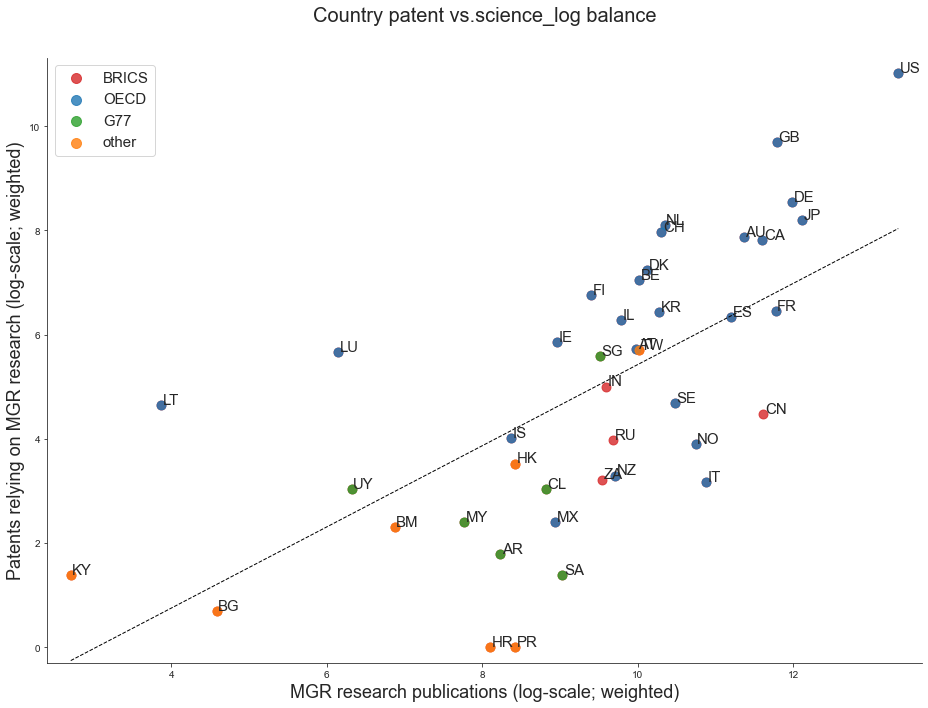

In [264]:
# Visualizing
# could add country/econ group colors

plt.figure(figsize=(130,180))
sns.set_style('white')
sns.set_style('ticks')


# Using regplot to create the scatter plot with 95% confidence interval and a regression line
size = 10
g = sns.lmplot(x='times cited by secondary science_log', y='times cited by secondary patents_log', data=df_science_vs_patent_totals_weighted_log, height=size, aspect=size*1.3/size, markers='o', fit_reg = False, scatter_kws={"s": size*8, "color":"tab:red"}).set(xlim=(df_science_vs_patent_totals_weighted_log['times cited by secondary science_log'].describe()['min']-0.3,df_science_vs_patent_totals_weighted_log['times cited by secondary science_log'].describe()['max']+0.3),ylim=(df_science_vs_patent_totals_weighted_log['times cited by secondary patents_log'].describe()['min']-0.3,df_science_vs_patent_totals_weighted_log['times cited by secondary patents_log'].describe()['max']+0.3))
sns.regplot(x='times cited by secondary science_log', y='times cited by secondary patents_log', data=df_science_vs_patent_totals_weighted_log[df_science_vs_patent_totals_weighted_log['econ_group'] == 'OECD'], fit_reg = False, scatter_kws={"s":size*8, "color":"tab:blue"})#ic use of MGRs (CoR)")
sns.regplot(x='times cited by secondary science_log', y='times cited by secondary patents_log', data=df_science_vs_patent_totals_weighted_log[df_science_vs_patent_totals_weighted_log['econ_group'] == 'G77'], fit_reg = False, scatter_kws={"s":size*8, "color":"tab:green"})#ic use of MGRs (CoR)")
sns.regplot(x='times cited by secondary science_log', y='times cited by secondary patents_log', data=df_science_vs_patent_totals_weighted_log[df_science_vs_patent_totals_weighted_log['econ_group'] == 'other'], fit_reg = False, scatter_kws={"s": size*8, "color":"tab:orange"})#ic use of MGRs (CoR)")


for i, countries in enumerate (list(df_science_vs_patent_totals_weighted_log['affiliation_country'])):
    #if countries in list(df_science_vs_patent_totals_weighted_log['affiliation_country'][(df_science_vs_patent_totals_weighted_log['times cited by secondary patents_log'] >= 1250) & (df_science_vs_patent_totals_weighted_log['times cited by secondary science_log'] >= 60000)]): # this is to label only those that 
        plt.annotate(countries, (df_science_vs_patent_totals_weighted_log['times cited by secondary science_log'][i]+0.02, df_science_vs_patent_totals_weighted_log['times cited by secondary patents_log'][i]+0.02),fontsize=size*1.5)

lgnd = plt.legend(scatterpoints=1, loc='upper left', labels=['BRICS', 'OECD','G77', 'other'], fontsize = 15, markerscale = 0.2)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
lgnd.legendHandles[3]._sizes = [100] 


sns.regplot(x='times cited by secondary science_log', y='times cited by secondary patents_log', data=df_science_vs_patent_totals_weighted_log, scatter=False, ci=None, ax=g.axes[0, 0], line_kws={"color":"black","alpha":1,"lw":1,'linestyle':'--'})

        
plt.title('Country patent vs.science_log balance', size= 20, y = 1.05)
plt.xlabel('MGR research publications (log-scale; weighted)', fontsize =size*1.8)
plt.ylabel('Patents relying on MGR research (log-scale; weighted)', fontsize =size*1.8)
#plt.xscale('log')
#plt.yscale('log')

plt.tight_layout()
plt.savefig('PATH\plots\Science_patent_totals_weighted_logs[OBIS_and_patents].svg', format="svg")
plt.savefig('PATH\plots\Science_patent_totals_weighted_logs[OBIS_and_patents].jpg', format="jpg")

In [38]:
# export the data
df_suppl4 = pd.merge(df_sci_pat_plot, df_knowledge, on = 'Country', how = 'outer').drop(columns = {'balance_sum'}).rename(columns = {'provided knowledge flow':'Provided knowledge flow', 'used knowledge flow': 'Used knowledge flow'})

In [45]:
df_suppl4.to_excel('PATH\data\supplementary_files_paper1\countries_suppl4.xlsx', index = False)

In [43]:
df_suppl4['Papers'][0]

5583.366250878758